In [22]:
##TODO -> try LLM models (chat gpt or bert), 
# would be good to use both title and body

In [72]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import string
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import requests
from tqdm import tqdm
import xgboost as xgb
tqdm.pandas()

In [24]:
df_merged = pd.read_csv("../data/merged_datasetes_balanced.csv")

In [36]:
# Actually there is no need to split it here, only to stay consistent with other notebooks
x_train, x_test, y_train, y_test = train_test_split(
    df_merged["title"], 
    df_merged["clickbait"],
    test_size=0.2, 
    random_state=42
)

In [64]:
n = 100

x_train = x_train[:n]
y_train = y_train[:n]

x_test = x_test[:n]
y_test = y_test[:n]

# Direct prompt 

In [26]:
file_path = r"C:\Users\Mateusz\Desktop\api_key_chat_gpt_kubita.txt" 

with open(file_path, 'r') as file:
    api_key = file.read()

In [52]:
# We can play with prompt :)
def get_chat_gpt_answer(title):
    res = requests.post(f"https://api.openai.com/v1/chat/completions",
    headers = {
      "Content-Type": "application/json",
      "Authorization": f"Bearer {api_key}"
    },
    json={
      "model": "gpt-4o",
      "messages": [
          {
              "role": "user",
              "content": f"Decide if this is fake news or not. If fake news return 1, if not fake news return 0, nothing more. This is title:{title}"
          },
      ],
    }).json()

    # Sometimes the model returns string explanation, e.g. 
    # "I'm unable to provide real-time news verification or access real-time information. 
    # Please consult reliable news sources or fact-checking websites to determine the authenticity of this news.
    answer = res["choices"][0]["message"]["content"]
    
    try:
        answer_int = int(answer)
    except:
        answer_int = 0
        
    return answer_int

In [53]:
get_chat_gpt_answer('Donald Trump gives incredible speech in California. ')

1

In [54]:
predictions = x_test.progress_apply(get_chat_gpt_answer)

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:17<00:00,  1.76it/s]


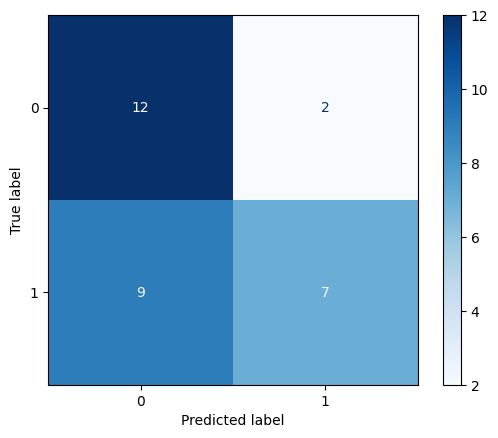

In [57]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, predictions)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Embeddings

In [58]:
def return_embeddings_chat(prompt):
    res = requests.post(f"https://api.openai.com/v1/embeddings",
        headers = {
          "Content-Type": "application/json",
          "Authorization": f"Bearer {api_key}"
        },
        json={
          "model": "text-embedding-3-large",
          "encoding_format": "float",
          "input": f"{prompt}"
        }).json()
    return res["data"][0]["embedding"]

In [66]:
return_embeddings_chat('Hello everyone')[:3]

[-0.049212195, 0.01368497, -1.7196902e-05]

In [74]:
embeddings_train = x_train.progress_apply(return_embeddings_chat)
embeddings_x_train_df = pd.DataFrame(embeddings_train.tolist())

embeddings_test = x_test.progress_apply(return_embeddings_chat)
embeddings_x_test_df = pd.DataFrame(embeddings_test.tolist())

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:26<00:00,  1.14it/s]


In [75]:
embeddings_x_train_df.head(2)

,0,1,2,3,4,5,6,7,8,9,...,3062,3063,3064,3065,3066,3067,3068,3069,3070,3071
0,-0.029559,-0.043036,0.000394,-0.033223,0.011122,-0.010411,-0.010115,-0.001889,0.025213,0.033950,...,-0.016521,-0.013591,-0.001281,0.005701,0.032315,-0.020624,-0.004721,-0.004191,-0.016384,-0.018308
1,-0.054682,-0.025644,-0.013326,-0.019625,-0.067360,0.010437,-0.011373,0.019305,0.009292,0.032287,...,-0.003185,-0.004150,-0.022314,-0.020874,-0.007752,0.011814,0.000231,-0.030734,-0.029726,-0.012430


# Model fitting with embeddings

In [76]:
xgb_model = xgb.XGBClassifier(random_state = 0)
xgb_model.fit(embeddings_x_train_df, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=0, ...)

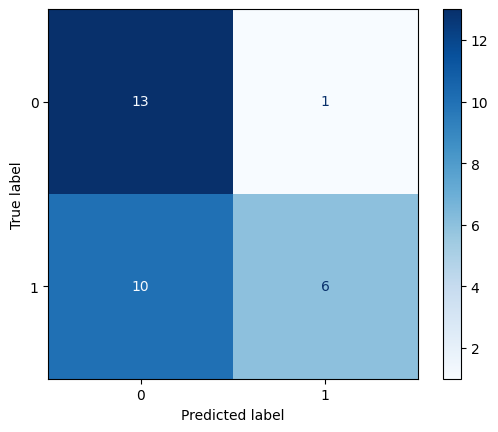

In [77]:
pred_xgb = xgb_model.predict(embeddings_x_test_df)

cm = confusion_matrix(y_test, pred_xgb)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [78]:
print(classification_report(y_test, pred_xgb))

              precision    recall  f1-score   support

           0       0.57      0.93      0.70        14
           1       0.86      0.38      0.52        16

    accuracy                           0.63        30
   macro avg       0.71      0.65      0.61        30
weighted avg       0.72      0.63      0.61        30

